In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
from collections import deque
from scipy.optimize import minimize
import time
import seaborn as sns
sns.set_theme()
import pickle
from scipy.integrate import quad
from scipy.linalg import norm

In [2]:
# Load estimations
with open("saved_estimations/univariate_estimations", 'rb') as f:
    a = pickle.load(f)
    _, list_log = a[0], [a[i] for i in range(1,len(a))]

list_log[0].shape

(3, 4, 6, 2, 10, 50)

In [3]:
estimations, loglike_real, loglike_estim, estimation_time, simulated_nb_points = list_log

In [4]:
# Averages 
list_avg = [np.mean(i, axis=-1) for i in list_log]
avg_estimations, avg_loglike_real, avg_loglike_estim, avg_estimation_time, avg_simulated_points = list_avg

In [5]:
std_dev_n = (50/49) * (np.mean(estimations**2, axis=-1) - avg_estimations ** 2)


# Functions

In [6]:
mu = 1.0
alpha = 0.5
beta = 1.0
noise_levels = np.round(mu/(1-alpha) * np.array([0.2 * k for k in range(1,11)]), 2)
idx_noise = len(noise_levels)
noise_signal_proportion = np.array([0.2 * k for k in range(1,11)])
horizons = [250 * (2**k) for k in range(0, 6)]
print(mu/(1-alpha), noise_levels, horizons)

2.0 [0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4. ] [250, 500, 1000, 2000, 4000, 8000]


In [7]:
# Functions

def spectral_f_exp(w, theta):
    mu, alpha, beta = theta
    avg = mu / (1 - alpha)

    return avg * (1 + alpha * (beta**2) * (2 - alpha)/((beta*(1 - alpha))**2 + w**2)) / (2 * np.pi)


def spectral_f_exp_noised(w, theta):
    mu, alpha, beta, lambda0 = theta
    f_val = spectral_f_exp(w, (mu, alpha, beta))
    avg = mu / (1 - alpha)

    return f_val + lambda0/(2 * np.pi)


def spectral_f_exp_grad(w, theta):
    mu, alpha, beta = theta
    avg = mu / (1 - alpha)
    D_ab = (beta * (1 - alpha)) ** 2 + w**2
    C_ab = 1 + alpha * (beta**2) * (2 - alpha)/D_ab
    f_val = avg * C_ab / (2 * np.pi)
    grad = np.zeros(3)
    grad[0] = C_ab / (1 - alpha)
    grad[1] = mu * C_ab * (2 * (beta**2) / D_ab + 1 / (1 - alpha)**2)
    grad[2] = 2 * avg * alpha * beta * (2 - alpha) * (w**2) / (D_ab**2)
    grad /= (2 * np.pi)

    return f_val, grad[0], grad[1], grad[2]


def spectral_f_exp_noised_grad(w, theta, noise):
    mu, alpha, beta = theta
    f_val, grad0, grad1, grad2 = spectral_f_exp_grad(w, (mu, alpha, beta))

    return f_val + noise/(2 * np.pi), grad0, grad1, grad2


def spectral_log_likelihood_grad(theta, f, M, tList, noise):
    T = tList[-1]
    f_array = np.array([f(2 * np.pi * j / T, theta, noise) for j in range(1, M+1)])
    f_val, grad = f_array[:, 0], f_array[:, 1:]
    periodogram = np.array([bartlett_periodogram(2 * np.pi * j / T, tList) for j in range(1, M+1)])
    #pll = -(1/T) * np.sum(np.log(f_array) + (1/f_array - 1) * periodogram)
    pll = -(1/T) * np.sum(np.log(f_val) + (1/f_val) * periodogram)
    aux = (1/f_val) * (1 - (1/f_val) * periodogram)
    pll_grad = -(1/T) * np.sum(grad * aux.reshape(M, 1), axis=0)

    return -pll, -pll_grad

def bartlett_periodogram(w, tList):
    T = tList[-1]
    t_aux = np.array(tList[1:-1])
    dt = np.sum(np.exp(1j * w * t_aux))
    return ((1 / (2*np.pi * T)) * dt * np.conj(dt)).real

def spectral_log_likelihood_grad_precomputed(theta, f, M, tList, periodogram, noise):
    T = tList[-1]
    f_array = np.array([f(2 * np.pi * j / T, theta, noise) for j in range(1, M+1)])
    f_val, grad = f_array[:, 0], f_array[:, 1:]
    periodogram = periodogram
    #pll = -(1/T) * np.sum(np.log(f_array) + (1/f_array - 1) * periodogram)
    #print((np.log(f_val) + (1/f_val) * periodogram)[0:5])
    pll = -(1/T) * np.sum(np.log(f_val) + (1/f_val) * periodogram)
    aux = (1/f_val) * (1 - (1/f_val) * periodogram)
    pll_grad = -(1/T) * np.sum(grad * aux.reshape(M, 1), axis=0)
    return -pll, -pll_grad


In [8]:
def comparison(x, theta, theta_prime):
    return (spectral_f_exp_noised(x, theta) - spectral_f_exp_noised(x, theta_prime))**2
def mean_intensity(c):
    return c[0]/(1-c[1]) + c[2]

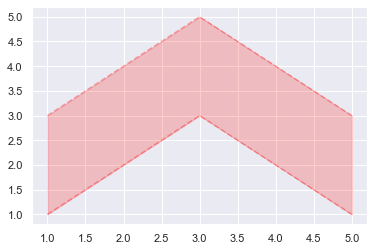

In [9]:
def plot_with_confidence(x, y_down, y_up, ax, c='blue', alpha=0.2):
    ax.plot(x, y_down, '--', color=c, alpha=alpha*1.5)
    ax.plot(x, y_up, '--', color=c, alpha=alpha*1.5)
    ax.fill_between(x, y_down, y_up, color=c, alpha=alpha)

x = [1, 2, 3, 4, 5]
y_down = [1, 2, 3, 2, 1]
y_up = [3, 4, 5, 4, 3]

fig, ax = plt.subplots()

plot_with_confidence(x, y_down, y_up, ax, c='red', alpha=0.2)

In [10]:
def obtain_theta_prime(theta, estimations, idx_parameter, repetitions):
    return np.concatenate((estimations[:idx_parameter, idx_parameter, :], 
                    np.array([[theta[idx_parameter,0]]*repetitions]),
                    estimations[idx_parameter:, idx_parameter,:]))

# Comparison w.r.t. T and estimation time

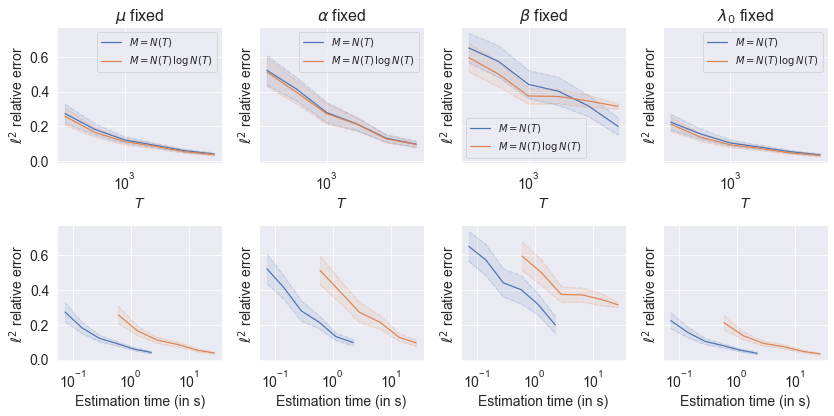

In [40]:
# Relative error wrt T and estimation time
idx = 3
repetitions = 50
linestyles = ["solid", "dashdot", "dotted"]
titles = [r"$\mu$ fixed", r"$\alpha$ fixed", r"$\beta$ fixed", r"$\lambda_0$ fixed"]
labels = [r"$M=N(T)$", 
         r"$M=N(T)\,\log N(T)$"]
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16, 'axes.labelsize': 14,
                             'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 10,
                             })  
fig, ax = plt.subplots(2, 4, figsize=(5.90666*2, 6), sharey=True)

for idx_parameter in range(4):
    for j in range(2):
        aux = np.zeros((3, len(horizons)))
        aux2 = np.zeros((3, len(horizons)))
        theta = np.array([mu, alpha/beta, beta, noise_levels[idx]]).reshape((4,1))

        theta_norm = norm(theta, axis=0)

        for i in range(len(horizons)):
            #theta_prime = np.concatenate((np.array([[mu]*50]), estimations[:, 0, i, j, idx, :]), axis=0)
            theta_prime = obtain_theta_prime(theta, estimations[:, :, i, j, idx, :], idx_parameter, repetitions)
            errors = norm(theta_prime - theta, axis=0) / theta_norm
            mean = np.mean(errors)
            std_dev = (50/49) * (np.mean(errors**2) - mean**2)
            # Error of mean
            aux[1, i] = mean

            # Upper and lower bands
            aux[0, i] = mean - 1.96 * np.sqrt(std_dev/50)
            aux[2, i] = mean + 1.96 * np.sqrt(std_dev/50)
            #aux[i, :] = errors

        ax[1, idx_parameter].plot(avg_estimation_time[0, :, j, idx], aux[1, :], c="C" + str(j), linestyle=linestyles[0],
                    label=labels[j])
        plot_with_confidence(avg_estimation_time[0, :, j, idx], aux[0, :], aux[2, :], ax[1, idx_parameter], c="C" + str(j), alpha=0.1)
        ax[0, idx_parameter].plot(horizons, aux[1, :], c="C" + str(j), linestyle=linestyles[0],
                    label=labels[j])
        plot_with_confidence(horizons, aux[0, :], aux[2, :], ax[0, idx_parameter], c="C" + str(j), alpha=0.1)

    ax[0,idx_parameter].set_xscale("log")
    ax[1,idx_parameter].set_xscale("log")
    ax[0,idx_parameter].set_xlabel(r"$T$")
    ax[1,idx_parameter].set_xlabel(r"Estimation time (in s)")
    ax[0,idx_parameter].set_ylabel(r"$\ell^2$ relative error")
    ax[1,idx_parameter].set_ylabel(r"$\ell^2$ relative error")
    ax[0,idx_parameter].set_title(titles[idx_parameter])
    ax[0,idx_parameter].legend()
#fig.suptitle(r"Noise level: $\lambda_0 = {}$".format(noise_levels[idx]))
plt.tight_layout()
plt.savefig("univariate_images/l2_error_wrt_nbpoints.pdf", format="pdf", bbox_inches="tight")

# WRT Noise

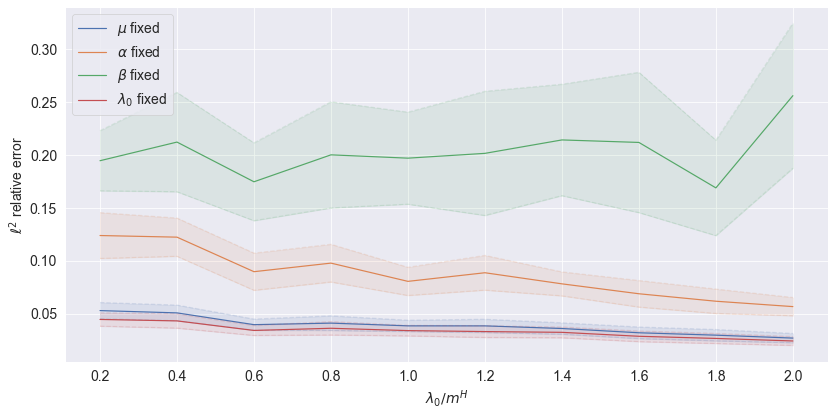

In [50]:
#l2 errors with confidence bands (N)
idx = 3
repetitions = 50
linestyles = ["solid", "dashdot", "dotted"]
titles = [r"$\mu$ fixed", r"$\alpha$ fixed", r"$\beta$ fixed", r"$\lambda_0$ fixed"]
labels = [r"$M=N(T)$", 
         r"$M=N(T)\,\log N(T)$"]
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16, 'axes.labelsize': 14,
                             'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 14,
                             })  
fig, ax = plt.subplots(figsize=(5.90666*2, 6))

for idx_parameter in range(4):
    for j in range(1):
        aux = np.zeros((3, len(noise_levels)))
        aux2 = np.zeros((3, len(noise_levels)))
        for i in range(len(noise_levels)):
            theta = np.array([mu, alpha/beta, beta, noise_levels[i]]).reshape((4,1))
            theta_norm = norm(theta)

            theta_prime = obtain_theta_prime(theta, estimations[:, :, -1, j, i, :], idx_parameter, repetitions)
            errors = norm(theta_prime - theta, axis=0) / theta_norm
            mean = np.mean(errors)
            std_dev = (50/49) * (np.mean(errors**2) - mean**2)
            # Error of mean
            aux[1, i] = mean

            # Upper and lower bands
            aux[0, i] = mean - 1.96 * np.sqrt(std_dev/50)
            aux[2, i] = mean + 1.96 * np.sqrt(std_dev/50)

        plot_with_confidence(noise_signal_proportion, aux[0, :], aux[2, :], ax, c="C" + str(idx_parameter), alpha=0.1)
        ax.plot(noise_signal_proportion, aux[1, :], label=titles[idx_parameter], c="C"+str(idx_parameter))

ax.set_xlabel(r"${\lambda_0}/{m^H}$")
ax.set_ylabel(r"$\ell^2$ relative error")
# ax.set_title(titles[idx_parameter])
ax.legend()
#fig.suptitle(labels[j])
ax.set_xticks(noise_signal_proportion)
plt.tight_layout()
plt.savefig("univariate_images/vector_max_hor_wrt_noise_N.pdf", format="pdf")

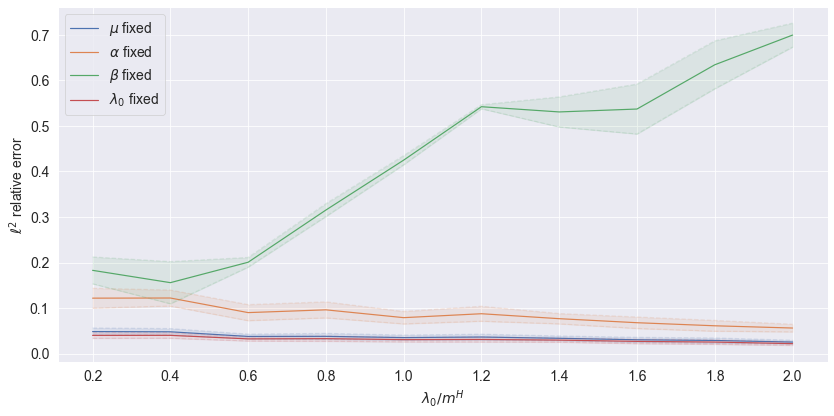

In [29]:
#l2 errors with confidence bands (N logN)
idx = 3
repetitions = 50
linestyles = ["solid", "dashdot", "dotted"]
titles = [r"$\mu$ fixed", r"$\alpha$ fixed", r"$\beta$ fixed", r"$\lambda_0$ fixed"]
labels = [r"$M=N(T)$", 
         r"$M=N(T)\,\log N(T)$"]
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14, 'axes.labelsize': 14,
                             'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 14,
                             })  
fig, ax = plt.subplots(figsize=(5.90666*2, 6))

for idx_parameter in range(4):
    for j in range(1, 2):
        aux = np.zeros((3, len(noise_levels)))
        aux2 = np.zeros((3, len(noise_levels)))
        for i in range(len(noise_levels)):
            theta = np.array([mu, alpha/beta, beta, noise_levels[i]]).reshape((4,1))
            theta_norm = norm(theta)

            theta_prime = obtain_theta_prime(theta, estimations[:, :, -1, j, i, :], idx_parameter, repetitions)
            errors = norm(theta_prime - theta, axis=0) / theta_norm
            mean = np.mean(errors)
            std_dev = (50/49) * (np.mean(errors**2) - mean**2)
            # Error of mean
            aux[1, i] = mean

            # Upper and lower bands
            aux[0, i] = mean - 1.96 * np.sqrt(std_dev/50)
            aux[2, i] = mean + 1.96 * np.sqrt(std_dev/50)

        plot_with_confidence(noise_signal_proportion, aux[0, :], aux[2, :], ax, c="C" + str(idx_parameter), alpha=0.1)
        ax.plot(noise_signal_proportion, aux[1, :], label=titles[idx_parameter], c="C"+str(idx_parameter))

ax.set_xlabel(r"${\lambda_0}/{m^H}$")
ax.set_ylabel(r"$\ell^2$ relative error")
# ax.set_title(titles[idx_parameter])
ax.legend()
#fig.suptitle(labels[j])
ax.set_xticks(noise_signal_proportion)
plt.tight_layout()
#plt.savefig("univariate_images/vector_max_hor_wrt_noise_NlogN.pdf", format="pdf")

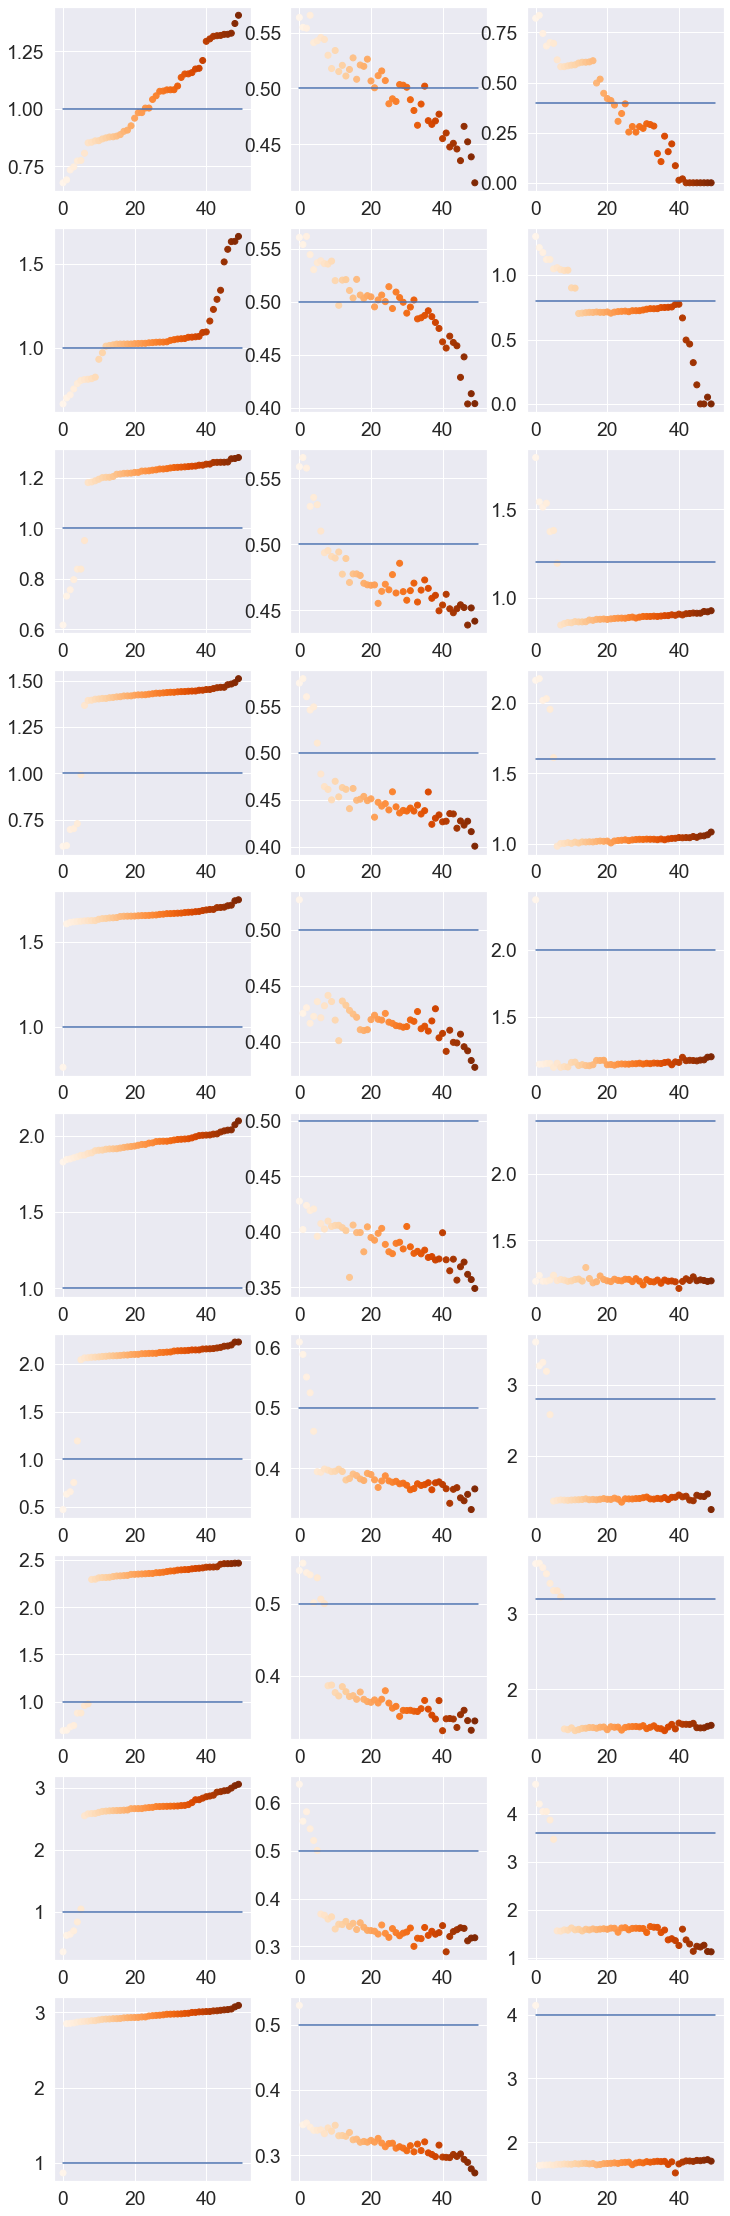

In [19]:
# See compensation for beta fixed for each noise level, M = N log N
idx_fixed = 2 # Beta fixed
idx_parameter = 0 # Mu estimations
idx_noise = 2 # Lambda_0 = 1.2
fig, ax = plt.subplots(len(noise_levels), 3, figsize=(12,40))
for idx_noise in range(len(noise_levels)):
    theta = np.array([mu, alpha, noise_levels[idx_noise]])
    sort_id = np.argsort(estimations[0, idx_fixed, -1, 1, idx_noise, :])
    estimations_beta = estimations[:, idx_fixed, -1, 1, idx_noise, sort_id] 
    for idx_parameter in range(3):
        ax[idx_noise, idx_parameter].scatter(np.arange(50), estimations_beta[idx_parameter, :], 
                      c=np.arange(50), cmap="Oranges")
        ax[idx_noise, idx_parameter].plot([0,50], [theta[idx_parameter]]*2)


# Appendix F for M = N

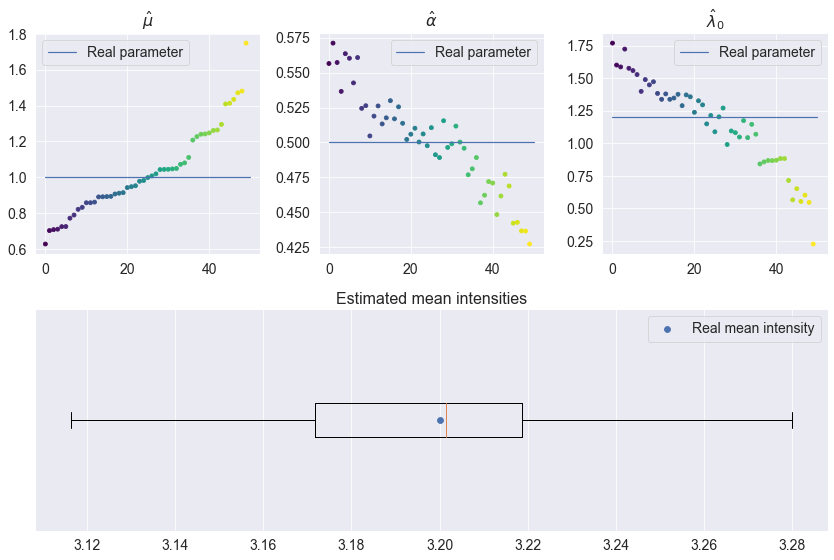

In [48]:
# See compensation of estimaitons for beta fixed
idx_fixed = 2 # Beta fixed
idx_noise = 2 # Lambda_0 = 1.2
idx_M = 0 # M = N
titles = [r"$\hat\mu$", r"$\hat\alpha$", r"$\hat\lambda_0$", "Estimated mean intensities"]

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16, 'axes.labelsize': 14,
                             'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 14,
                             'lines.markersize': 4.0,
                             })  
fig, ax = plt.subplots(2, 3, figsize=(5.90666*2, 8))
gs = ax[1, 0].get_gridspec()
for axis in ax[1, :]:
    axis.remove()
axbig = fig.add_subplot(gs[1, :])

theta = np.array([mu, alpha, noise_levels[idx_noise]])
sort_id = np.argsort(estimations[0, idx_fixed, -1, idx_M, idx_noise, :])
estimations_beta = estimations[:, idx_fixed, -1, idx_M, idx_noise, sort_id] 
for idx_parameter in range(3):
    ax[0, idx_parameter].scatter(np.arange(50), estimations_beta[idx_parameter, :], 
                  c=np.arange(50), cmap="viridis")
    ax[0, idx_parameter].plot([0,50], [theta[idx_parameter]]*2, label="Real parameter")
    ax[0, idx_parameter].legend()
    ax[0, idx_parameter].set_title(titles[idx_parameter])
    
estimated_intensities = mean_intensity(estimations[:, idx_fixed, -1, idx_M, idx_noise, :])
props = {"linewidth":1}
axbig.boxplot(estimated_intensities, vert=False, boxprops=props, medianprops=props, whiskerprops=props, capprops=props)
rp = axbig.scatter([mean_intensity(theta)], [1], s=6**2)
axbig.set_title(titles[-1])
axbig.set_yticks([])
axbig.legend([rp], ['Real mean intensity'], loc='best')

plt.tight_layout()
plt.savefig("univariate_images/compensation_beta_N.pdf", format="pdf")
#plt.savefig("compensation_beta_N.png")

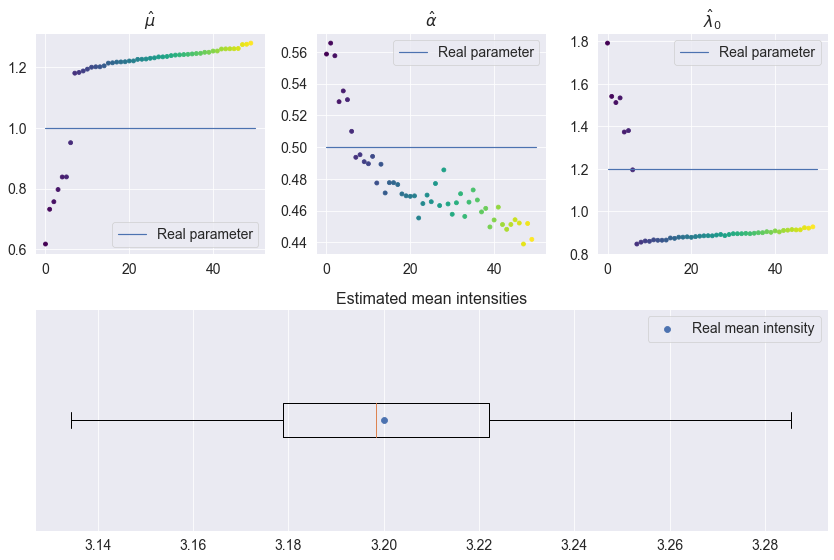

In [45]:
# See compensation of estimations for beta fixed
idx_fixed = 2 # Beta fixed
idx_noise = 2 # Lambda_0 = 1.2
idx_M = 1 # M = N log N
titles = [r"$\hat\mu$", r"$\hat\alpha$", r"$\hat\lambda_0$", "Estimated mean intensities"]
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16, 'axes.labelsize': 14,
                             'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 14,
                             'lines.markersize': 4.0,
                             })  
fig, ax = plt.subplots(2, 3, figsize=(5.90666*2, 8))
gs = ax[1, 0].get_gridspec()
for axis in ax[1, :]:
    axis.remove()
axbig = fig.add_subplot(gs[1, :])


theta = np.array([mu, alpha, noise_levels[idx_noise]])
sort_id = np.argsort(estimations[0, idx_fixed, -1, idx_M, idx_noise, :])
estimations_beta = estimations[:, idx_fixed, -1, idx_M, idx_noise, sort_id] 
for idx_parameter in range(3):
    ax[0, idx_parameter].scatter(np.arange(50), estimations_beta[idx_parameter, :], 
                  c=np.arange(50), cmap="viridis")
    ax[0, idx_parameter].plot([0,50], [theta[idx_parameter]]*2, label="Real parameter")
    ax[0, idx_parameter].legend()
    ax[0, idx_parameter].set_title(titles[idx_parameter])
    
estimated_intensities = mean_intensity(estimations[:, idx_fixed, -1, idx_M, idx_noise, :])
props = {"linewidth":1}
axbig.boxplot(estimated_intensities, vert=False, boxprops=props, medianprops=props, whiskerprops=props, capprops=props)
rp = axbig.scatter([mean_intensity(theta)], [1], s=6**2)
axbig.set_title(titles[-1])
axbig.set_yticks([])
axbig.legend([rp], ['Real mean intensity'], loc='best')

plt.tight_layout()
#plt.savefig("univariate_images/compensation_beta_NlogN.pdf", format="pdf")
#plt.savefig("compensation_beta_NlogN.png")

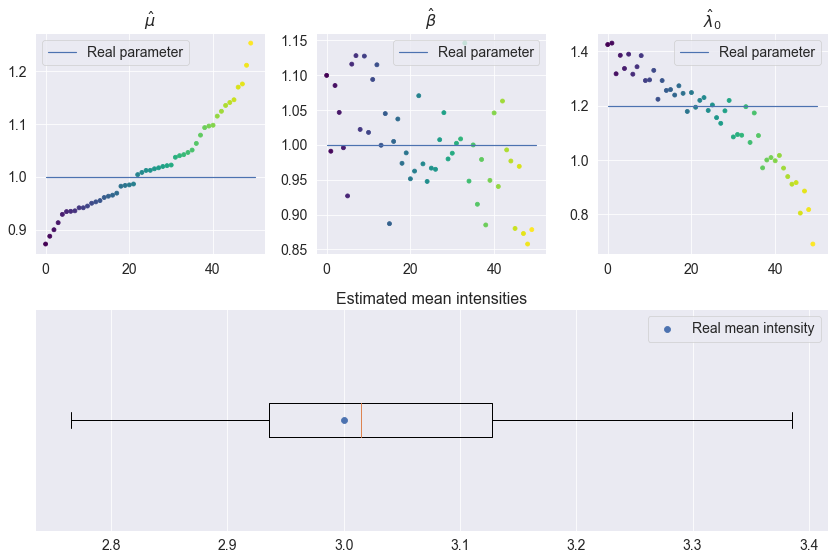

In [47]:
# # See compensation of estimations for alpha fixed
idx_fixed = 1 # Alpha fixed
idx_noise = 2 # Lambda_0 = 1.2
idx_M = 0 # M = N
doc_fixed = ["mu", "alpha", "beta", "lambda0"]
M_str = ["_N", "_NlogN"]
titles_param = np.array([r"$\hat \mu$", r"$\hat\alpha$", r"$\hat\beta$", r"$\hat\lambda_0$"])
titles_fixed = [r"$\mu$ fixed", r"$\alpha$ fixed", r"$\beta$ fixed", r"$\lambda_0$ fixed"]

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16, 'axes.labelsize': 14,
                             'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 14,
                             'lines.markersize': 4.0,
                             })  
fig, ax = plt.subplots(2, 3, figsize=(5.90666*2, 8))
gs = ax[1, 0].get_gridspec()
for axis in ax[1, :]:
    axis.remove()
axbig = fig.add_subplot(gs[1, :])


theta = np.array([mu, alpha, beta, noise_levels[idx_noise]])
theta_bis = theta[np.arange(4) != idx_fixed]
sort_id = np.argsort(estimations[0, idx_fixed, -1, idx_M, idx_noise, :])
estimations_beta = estimations[:, idx_fixed, -1, idx_M, idx_noise, sort_id] 

for idx_parameter in range(3):
    ax[0, idx_parameter].scatter(np.arange(50), estimations_beta[idx_parameter, :], 
                  c=np.arange(50), cmap="viridis")
    ax[0, idx_parameter].plot([0,50], [theta_bis[idx_parameter]]*2, label="Real parameter")
    ax[0, idx_parameter].legend()

for title, axou in zip(titles_param[np.arange(4) != idx_fixed], ax[0, :]):
    axou.set_title(title)
    
aux = obtain_theta_prime(theta.reshape(4,1), estimations[:, :, -1, idx_M, idx_noise, :], idx_fixed, repetitions)
estimated_intensities = mean_intensity(aux)
props = {"linewidth":1}
axbig.boxplot(estimated_intensities, vert=False, boxprops=props, medianprops=props, whiskerprops=props, capprops=props)
rp = axbig.scatter([mean_intensity(theta)], [1], s=6**2)
axbig.set_title("Estimated mean intensities")
axbig.set_yticks([])
axbig.legend([rp], ['Real mean intensity'], loc='best')

#print(np.corrcoef(estimations_beta)[0,:])
#plt.suptitle(titles_fixed[idx_fixed])
plt.tight_layout()
plt.savefig("univariate_images/compensation_" + str(doc_fixed[idx_fixed]) + str(M_str[idx_M]) + ".pdf", format="pdf")
#plt.savefig("compensation_" + str(doc_fixed[idx_fixed]) + str(M_str[idx_M]) + ".png")